# SPR 2022, Pre-conference Workshop
# Methods for Analyzing Neural Oscillations and Aperiodic Activity

## Lesson 1: Digital  Signal Processing and Simulations

In this notebook, we will go over some functions to simulate your own data using the NeuroDSP library
(https://neurodsp-tools.github.io/neurodsp/index.html)

### Set-up

#### Install necessary packages (for Colab) 

In [ ]:
!pip install neurodsp

#### Imports

In [1]:
# general 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Voytek Lab tools
from neurodsp import spectral
from neurodsp import filt
from neurodsp import sim
from neurodsp import utils

#### Settings

In [2]:
# signal params
N_SECONDS = 100 # signal duration
FS = 1000 # sampling frequnecy

In [3]:
# plotting params

# fontsize
mpl.rcParams['figure.titlesize'] = 18
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 10

# color
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['axes.facecolor'] = 'w'

#### Functions

In [4]:
def plot_signal_and_power(time, signal, freq, spectrum, title='', logscale=False, xlims=None):
    '''
    Plot time-series and corresponding power spectum

    Parameters
    ----------
    time : 1D array, float
        time-vector for signal
    signal : 1D array, float
        time-series e.g. LFP or EEG
    freq : 1D array, float
        frequency-vector for spectrum
    spectrum : 1D array, float
        power spectrum of signal
    title : str, optional
        figure title. The default is ''.
    logscale : bool, optional
        whether to plot the spectrum in log-log space. The default is False.
    xlims : 1D array (len=2), optional
        x-axis limits for time-series plot ([lower_limit, upper_limit]). 
        The default is None.

    '''
    # create figure
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=[12,4], gridspec_kw={'width_ratios': [3, 1]}, constrained_layout=True)
    fig.suptitle(title)

    # plot signal
    ax1.set(xlabel='time (s)', ylabel='voltage (au)', title='Time-series')
    ax1.plot(time, signal)
    if xlims:
        ax1.set_xlim(xlims)
        
    # plot spectra
    ax2.set(xlabel='frequency (Hz)', ylabel='power (au)', title='Power Spectral Density')
    ax2.plot(freq, spectrum);
    ax2.set_xlim([.1,200])
    if logscale:
        ax2.set(xscale='log', yscale='log')

    

### White Noise Signal - equal power over all frequencies
We will first simulate a white noise signal.

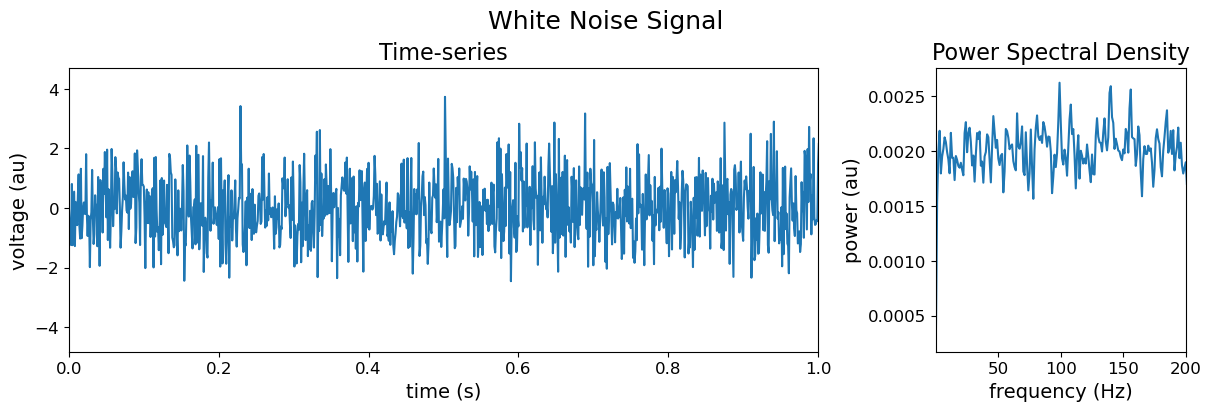

In [5]:
# simulate white noise signal
signal_white = np.random.normal(loc=0, scale=1, size=utils.data.compute_nsamples(N_SECONDS, FS))
time = utils.create_times(N_SECONDS, FS)

# compute power spectrum of white noise signal
freq, psd_white = spectral.compute_spectrum(signal_white, FS)

# plot
plot_signal_and_power(time, signal_white, freq, psd_white, title='White Noise Signal', xlims=[0,1])


We see that white noise signals have approximately equal power at all frequencies. Although this signal has no oscillatory activity, every frequency band shows some power. This simulation highlights the fact that observing power in a specific frequency band of interest alone is not evidence of a neural oscillation.

### Sinusoidal Oscillations
We will now simulate sinusoidal signals and signals composed of multiple oscillations.

#### simulate a sinusoidal oscillation

In [6]:
# settings
freq_oscillation = 10 # oscillation peak frequency

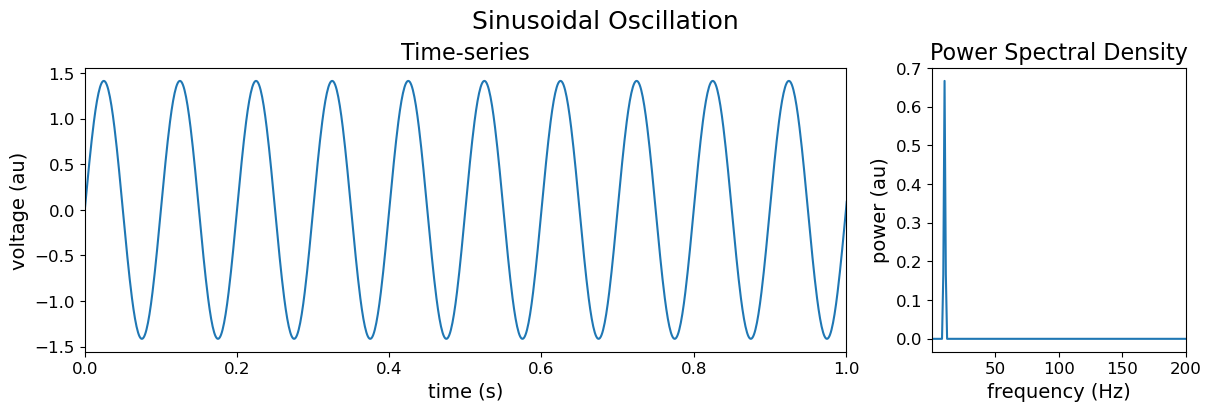

In [7]:
# simulate a sinusoidal oscillation
signal_sin = sim.sim_oscillation(N_SECONDS, FS, freq_oscillation)

# compute power spectrum of 10 Hz signal
_, psd_sin = spectral.compute_spectrum(signal_sin, FS)

# plot
plot_signal_and_power(time, signal_sin, freq, psd_sin, title='Sinusoidal Oscillation', xlims=[0,1])


We see that sinusoids are associated with power within a narrow frequency band. Here, we see a peak in the power spectrum at the frequency of the oscillation. Try changing the value of `freq_oscillation` and observe the effect on the power spectrum

#### simulate a signal containing *several* sinusoidal oscillations

In [8]:
# settings
freq_oscillations = [10, 35, 60] # oscillation peak frequency

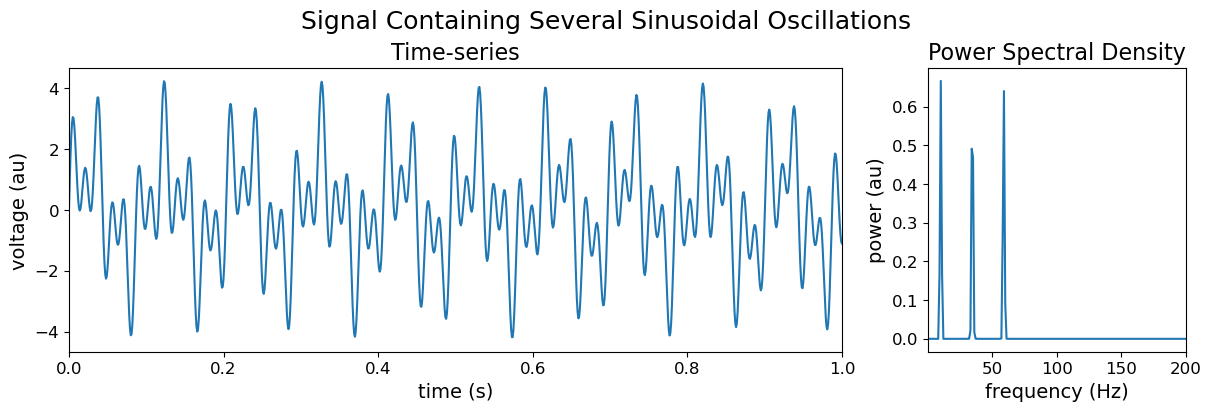

In [9]:
# simulate a sinusoidal oscillation
signal_sins = np.zeros_like(time)
for i_osc in range(len(freq_oscillations)):
    signal_sins += sim.sim_oscillation(N_SECONDS, FS, freq_oscillations[i_osc])

# compute power spectrum of several oscillations
_, psd_sins = spectral.compute_spectrum(signal_sins, FS)

# plot
plot_signal_and_power(time, signal_sins, freq, psd_sins, 
    title='Signal Containing Several Sinusoidal Oscillations', xlims=[0,1])


#### simulate a signal containing *many* sinusoidal oscillations

In [10]:
# settings
osc_freq = np.random.rand(10)*100 # oscillation peak frequency
osc_amp = np.random.rand(10) # oscillation amplitude

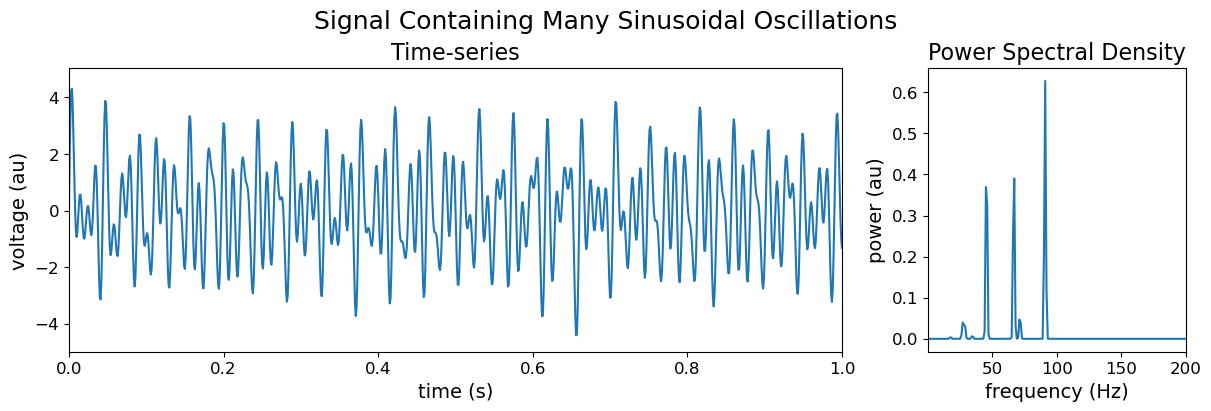

In [11]:
# simulate a sinusoidal oscillation
signal_sins2 = np.zeros_like(time)
for i_osc in range(len(osc_freq)):
    signal_sins2 += sim.sim_oscillation(N_SECONDS, FS, osc_freq[i_osc]) * osc_amp[i_osc]

# compute power spectrum of white noise signal
_, psd_sins2 = spectral.compute_spectrum(signal_sins2, FS)

# plot
plot_signal_and_power(time, signal_sins2, freq, psd_sins2, 
    title='Signal Containing Many Sinusoidal Oscillations', xlims=[0,1])


Despite the fact that the signal appears 'complex', we see that power is still concentrated within narrow frequency bands, determined by `osc_freq`.

### Non-stationary Oscillations (Bursts)

We will now simulate non-stationary oscillations. Neural signals are non-stationary i.e. the spectral content changes over time. Oscillations have been shown to arise as transient 'bursts,' arising for tens to hundreds of milliseconds (see Stokes and Spaak, 2016; and Jones, 2016).

In [12]:
# settings
freq_oscillation = 10 # oscillation peak frequency
cycle = 'sine' # oscillation waveform shape

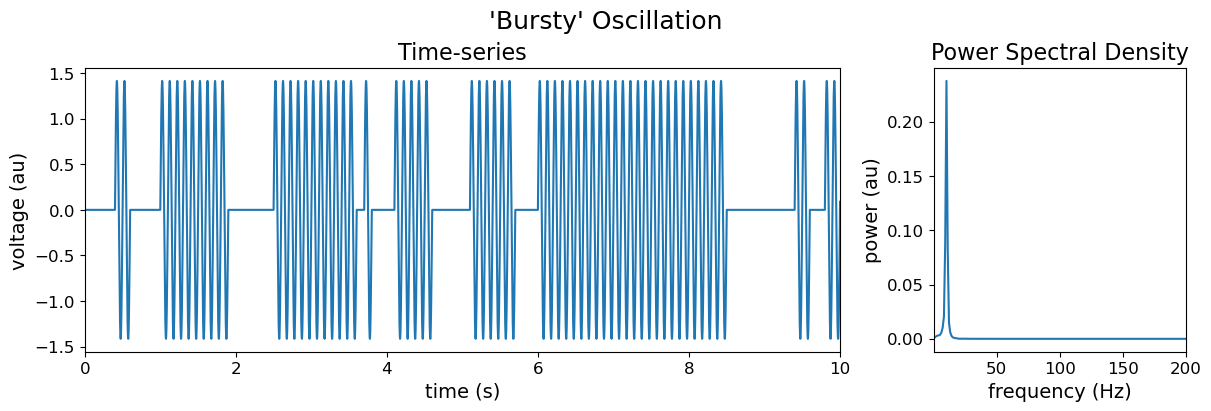

In [13]:
# simulate a sinusoidal oscillation
signal_bursty =  sim.sim_bursty_oscillation(n_seconds=N_SECONDS, fs=FS, freq=freq_oscillation, cycle=cycle)

# compute power spectrum of white noise signal
_, psd_bursty = spectral.compute_spectrum(signal_bursty, FS)

# plot
plot_signal_and_power(time, signal_bursty, freq, psd_bursty, title="'Bursty' Oscillation", xlims=[0,10])

### Non-sinusoidal Oscillations
We will now simulate non-sinusoidal oscillations. Neural rhythms have been shown to be non-sinusoidal, often displaying 'sawtooth' shapes and other phase distortions. These waveform features are physiologically relevant, but require more detailed analyses which we will explore later in this workshop. 

In [14]:
# settings
freq_oscillation = 10 # oscillation peak frequency
cycle = 'sawtooth' # oscillation waveform shape
width = 1 # sawtooth waveform parameter (0: fast rise. 0.5: symmetric. 1: fast decay)

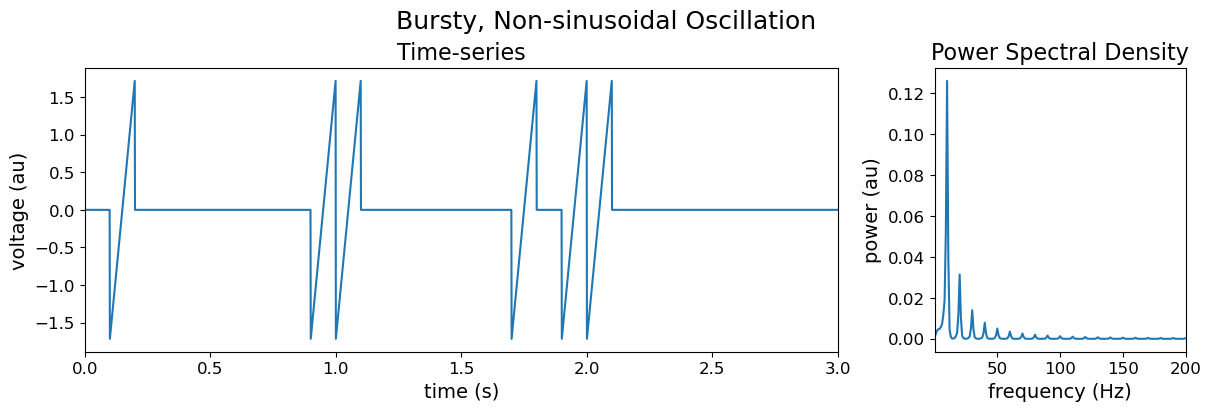

In [15]:
# simulate a sinusoidal oscillation
signal_saw =  sim.sim_bursty_oscillation(n_seconds=N_SECONDS, fs=FS, freq=freq_oscillation, cycle=cycle, width=width)

# compute power spectrum of white noise signal
_, psd_saw = spectral.compute_spectrum(signal_saw, FS)

# plot
plot_signal_and_power(time, signal_saw, freq, psd_saw,
    title='Bursty, Non-sinusoidal Oscillation', xlims=[0,3])

Here we see that the non-oscillatory nature of our signal introduces harmonics in the power spectrum. Despite the fact that a single rhythm exists at the frequency determined by `freq_oscillation', additional peaks can be seen at integer multiples of this frequewncy. This simulation highlights the fact that a peak in the power spectrum is not necessarily evidence of an oscillation at that frequency.  

### Oscillation Embedded in Aperiodic Activity 
We will now simulate an oscillation embedded in aperiodic (or non-oscillatory) activity. Neural data (including LFP, EEG, ECoG, and MEG) display 1/f-like spectral content, where power inversely proportional to frequency. This contrasts the white noise signals we simulated earlier, where power was equal at all frequencies. This aperiodic activity is physiologically relevant, and must be considered when analyzing oscillations.  

In [16]:
# settings
sim_components = {'sim_oscillation': {'freq' : 10},
                  'sim_powerlaw': {'exponent' : -2}} # aperiodic exponent (spectral slope)

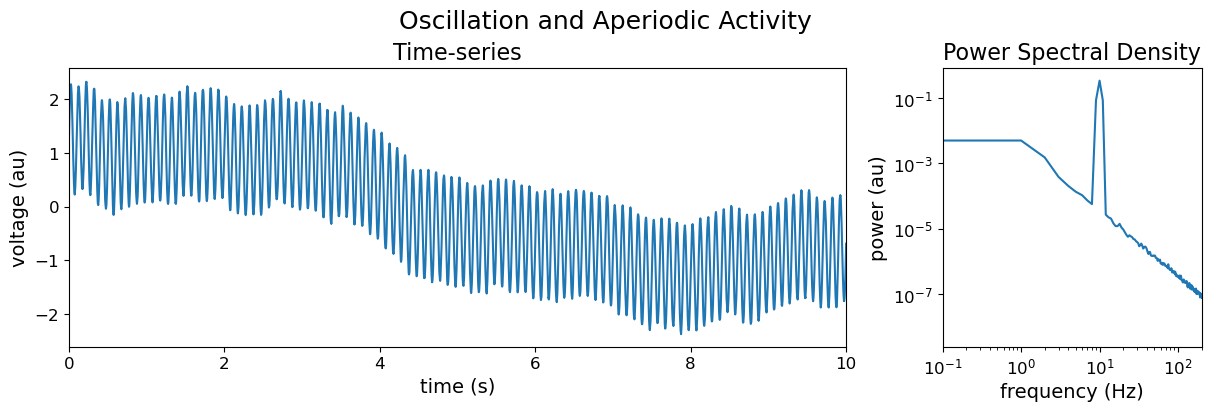

In [17]:
# simulate a sinusoidal oscillation
signal_comb =  sim.sim_combined(n_seconds=N_SECONDS, fs=FS, components=sim_components)

# compute power spectrum of white noise signal
_, psd_comb = spectral.compute_spectrum(signal_comb, FS)

# plot
plot_signal_and_power(time, signal_comb, freq, psd_comb,
    title='Oscillation and Aperiodic Activity',
    logscale=True, xlims=[0,10])


Here we see that the aperiodic signal contributes to power at all frequencies, with power decreasing at increasing frequency. Similar to the previous simulations, the sinusoidal oscillation contributes to power within a narrow frequency band. Careful quantification of these components is necessary to analyze their respective contributions to cognition and behavior. 